## Thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numba import cuda
import time
# from matrix_on_device import *

## SVM phiên bản tuần tự

In [ ]:
# %%writefile SVM.py
import numpy as np

class SVM():
  def __init__(self,C=1.0):
    # C error terms
    self.C = C
    self.w = 0
    self.b = 0

  # Hinge Loss Function / Calculation
  def hingeloss(self, w, b, x, y):
    # Regularizer term
    reg = 0.5 * (w * w)

    for i in range(x.shape[0]):
      # Optimization term 
      opt_term = y[i] * ((np.dot(w, x[i])) + b)

      # calculating loss
      loss = reg + self.C * max(0, 1-opt_term)
    return loss[0][0]

  def fit(self, X, Y, batch_size=100, learning_rate=0.001, epochs=1000):
    # The number of features in X
    number_of_features = X.shape[1]

    # The number of Samples in X
    number_of_samples = X.shape[0]

    c = self.C

    # Creating ids from 0 to number_of_samples - 1
    ids = np.arange(number_of_samples)

    # Shuffling the samples randomly
    np.random.shuffle(ids)

    # creating an array of zeros
    w = np.zeros((1, number_of_features))
    b = 0
    losses = []

    # Gradient Descent logic
    for i in range(epochs):
      # Calculating the Hinge Loss
      l = self.hingeloss(w, b, X, Y)

      # Appending all losses 
      losses.append(l)
      
      # Starting from 0 to the number of samples with batch_size as interval
      # loop in each batch
      for batch_initial in range(0, number_of_samples, batch_size):
        gradw = 0
        gradb = 0

        # for every element in the batch
        # sum up gradient of w and b
        for j in range(batch_initial, batch_initial + batch_size):
          if j < number_of_samples:
            x = ids[j]
            ti = Y[x] * (np.dot(w, X[x].T) + b)

            if ti > 1:
              gradw += 0
              gradb += 0
            else:
              # Calculating the gradients
              #w.r.t w 
              gradw += c * Y[x] * X[x]
              # w.r.t b
              gradb += c * Y[x]

        # Updating weights and bias
        w = w - learning_rate * w + learning_rate * gradw
        b = b + learning_rate * gradb

    self.w = w
    self.b = b

    return self.w, self.b, losses
        
  def predict(self, X):
    prediction = np.dot(X, self.w[0]) + self.b # w.x + b
    return np.sign(prediction)

## SVM phiên bản song song

### Tham số

In [ ]:
# C = 1.0
# w = 0.01
# b = 0.01

## Hàm hỗ trợ

In [2]:
from numba import cuda
import math
import numpy as np

# add number to every element in vector
@cuda.jit
def add_num_vec_kernel(num,vec,out):
    ids = cuda.grid(1)

    if ids < vec.shape[0]:
        out[ids] = vec[ids] + num

# multiply a number with a vector
@cuda.jit
def mul_num_vec_kernel(num,vec,out):
    ids = cuda.grid(1)
    if ids < vec.shape[0]:
        out[ids] = vec[ids] * num

# add two vectors
@cuda.jit
def add_vec_vec_kernel(vec1,vec2,out):
    ids = cuda.grid(1)
    if ids < vec1.shape[0]:
        out[ids] = vec1[ids] + vec2[ids]

@cuda.jit
def mul_num_row_mat_kernel(num,mat,out,row):
    ids = cuda.grid(1)
    if ids < out.shape[0]:
        out[ids] = mat[row][ids] * num

@cuda.jit
def mul_num_col_mat_kernel(num,mat,out,col):
    ids = cuda.grid(1)
    if ids < out.shape[0]:
        out[ids] = mat[ids][col] * num

# add vector to matrix element-wise in every row
@cuda.jit
def add_vec_mat_kernel(vec,mat,out):
    row, col = cuda.grid(2)
    if row < mat.shape[0] and col < mat.shape[1]:
        out[row][col] = vec[col] - mat[row][col]

# add number to every element in matrix
@cuda.jit
def add_num_mat_kernel(num,arr,out):
    row,col = cuda.grid(2)
    if (row < arr.shape[0]) and (col < arr.shape[1]):
        out[row][col] = arr[row][col] + num

# multiply a number with a matrix element-wise
@cuda.jit
def mul_num_mat_kernel(num,arr,out):
    row,col = cuda.grid(2)
    if (row < arr.shape[0]) and (col < arr.shape[1]):
        out[row][col] = arr[row][col] * num


# function to multiply 2 matrix element wise
@cuda.jit
def mul_mat_mat_kernel(arr1,arr2,out):
    row,col = cuda.grid(2)

    if (row < arr1.shape[0]) and (col < arr1.shape[1]):
        out[row][col] = arr1[row][col] * arr2[row][col]


# function to add matrix element wise
@cuda.jit
def add_mat_mat_kernel(arr1,arr2,out):
    row,col = cuda.grid(2)

    if (row < arr1.shape[0]) and (col < arr1.shape[1]):
        out[row][col] = arr1[row][col] + arr2[row][col]


@cuda.jit
def dot_product_kernel(arr1,arr2,out):
    row,col = cuda.grid(2)
    if row < out.shape[0] and col < out.shape[1]:
        sum = 0
        for i in range(arr1.shape[1]):
            sum += arr1[row,i] * arr2[i,col]

    out[row,col] = sum

@cuda.jit
def dot_product_vec_row_mat_kernel(vec,mat,row, out):
    ids = cuda.grid(1)
    if ids < vec.shape[0]:
      cuda.atomic.add(out,0,vec[ids] * mat[row][ids])


# @cuda.jit
# def dot_product_mat_mat_row_kernel(mat1,mat2,out)

# cuda.jit
# def one_dot_product_kernel(arr1,arr2,out):
#    ids = cuda.grid(1)
#    if ids < arr2.shape[0]:
#        sum = 0


## Call kernel
# add a number to vector element-wise
def add_num_vec_device(num,d_arr, d_out, block_size = 32):
    grid_size = math.ceil(d_arr.shape[0] / block_size)
    add_num_vec_kernel[grid_size,block_size](num,d_arr,d_out)

# multiply a number with a vector
def mul_num_vec_device(num,d_arr, d_out, block_size = 32):
    grid_size = math.ceil(d_arr.shape[0] / block_size)
    mul_num_vec_kernel[grid_size,block_size](num,d_arr,d_out)

# add two vectors
def add_vec_vec_device(d_vec1,d_vec2,d_out,block_size = 32):
    grid_size = math.ceil(d_vec1.shape[0] / block_size)
    add_vec_vec_kernel[grid_size,block_size](d_vec1,d_vec2,d_out)

# add a number to matrix element-wise
def add_num_mat_device(num,d_arr, d_out, block_size = (32,32)):
    grid_size = (math.ceil(d_arr.shape[0] / block_size[0]),
             math.ceil(d_arr.shape[1] / block_size[1]))
    add_num_mat_kernel[grid_size,block_size](num,d_arr,d_out)

# multiply a number to matrix element-wise
def mul_num_mat_device(num,d_arr, d_out, block_size = (32,32)):
    grid_size = (math.ceil(d_arr.shape[0] / block_size[0]),
             math.ceil(d_arr.shape[1] / block_size[1]))
    mul_num_mat_kernel[grid_size,block_size](num,d_arr,d_out)

# multiply a row or column in a matrix with a number
def mul_num_one_rc_mat_device(num,d_arr,d_out,row=None,col=None,block_size=32):
    grid_size = math.ceil(d_arr.shape[0] / block_size)
    if row is not None:
        mul_num_row_mat_kernel[grid_size,block_size](num,d_arr,d_out,row)

    if col is not None:
        mul_num_col_mat_kernel[grid_size,block_size](num,d_arr,d_out,col)

# add two matrices
def add_mat_mat_device(d_arr1,d_arr2,d_out,block_size=(32,32)):
    grid_size = (math.ceil(d_arr1.shape[0] / block_size[0]),
             math.ceil(d_arr1.shape[1] / block_size[1]))
    add_mat_mat_kernel[grid_size,block_size](d_arr1,d_arr2,d_out)

# multiply two matrices element-wise
def mul_mat_mat_device(d_arr1,d_arr2,d_out,block_size=(32,32)):
    grid_size = ( math.ceil( d_arr1.shape[0] / block_size[0] ),
             math.ceil( d_arr1.shape[1] / block_size[1]) )

    mul_mat_mat_kernel[grid_size,block_size](d_arr1,d_arr2,d_out)

# dot product of two matrices
def dot_product_device(d_arr1,d_arr2,d_out,block_size=(32,32)):
    grid_size = (math.ceil(d_arr1.shape[0] / block_size[0]),
             math.ceil(d_arr2.shape[1] / block_size[1]))
    dot_product_kernel[grid_size,block_size](d_arr1,d_arr2,d_out)

def dot_product_vec_row_mat_device(d_vec,d_mat,row,out,block_size=32):
    grid_size = math.ceil(d_vec.shape[0] / block_size)
    dot_product_vec_row_mat_kernel[grid_size,block_size](d_vec,d_mat,row,out)
    
def add_vec_mat_device(d_vec,d_mat,d_out,block_size=(32,32)):
    grid_size = (math.ceil(d_mat.shape[0] / block_size[0]),
             math.ceil(d_mat.shape[1] / block_size[1]))
    add_vec_mat_kernel[grid_size,block_size](d_vec,d_mat,d_out)

In [3]:
@cuda.jit
def mul_vec_vec_kernel(vec1,vec2,out):
  ids = cuda.grid(1)
  if ids < vec1.shape[0]:
    out[ids] = vec1[ids] * vec2[ids]

def mul_vec_vec_device(d_vec1,d_vec2, d_out,block_size=32):
  grid_size = math.ceil(d_vec1.shape[0] / block_size)
  mul_vec_vec_kernel[grid_size,block_size](d_vec1,d_vec2,d_out)

In [4]:
@cuda.jit
def dot_product_mini_batch_kernel(vec,mat,out,batch_initial,batch_size,ids):
  row, col = cuda.grid(2)
  if row < batch_size and col < mat.shape[1]:
    if row + batch_initial < ids.shape[0]:
      x = ids[row + batch_initial]
    # tham khảo về hàm atomic - cuda.atomic.add(out,0,vec[ids] * mat[row][ids])
    # công thức tính - out[row] +=  vec[col] * mat[batch_initial + row][col]
      cuda.atomic.add(out,row,vec[col] * mat[x][col])

def dot_product_mini_batch_device(d_vec,d_mat,d_out,d_ids,batch_initial,batch_size, block_size = (32,32)):
  grid_size = (math.ceil(batch_size / block_size[0]),
                        math.ceil(d_mat.shape[1] / block_size[1]))
  dot_product_mini_batch_kernel[grid_size,block_size](d_vec,d_mat,d_out,batch_initial,batch_size,d_ids)

In [5]:
@cuda.jit
def to_zero_array_kernel(in_arr):
  ids = cuda.grid(1)
  if ids < in_arr.shape[0]:
    in_arr = 0

def to_zero_array_device(d_inArr,block_size=32):
  grid_size = math.ceil(d_inArr.shape[0] / block_size)
  to_zero_array_kernel[grid_size,block_size](d_inArr)

### Hàm Hinge Loss

In [ ]:
def hingeloss(w, b, x, y):
    # Regularizer term
    reg = 0.5 * (w * w)

    for i in range(x.shape[0]):
      # Optimization term
      opt_term = y[i] * ((np.dot(w, x[i])) + b)

      # calculating loss
      loss = reg + C * max(0, 1-opt_term)
    return loss[0][0]

In [ ]:
def hingeloss_device(d_w, b, d_x, y,d_reg,d_loss):
  # Regularizer term
  # reg = 0.5 * w * w
  mul_vec_vec_device(d_w,d_w,d_reg)
  mul_num_vec_device(0.5, d_reg,d_reg)

  for i in range(d_x.shape[0]):
    # Optimization term
    # opt_term = y[i] * ((np.dot(w, x[i])) + b)
    # dot_pro = np.dot(w,x[i]) + b
    dot_pro = 0
    dot_product_vec_row_mat_device(d_w,d_x,i,dot_pro)

    opt_term = y[i] * dot_pro
    error_term = C * max(0, 1 - opt_term)

    # calculating loss
    # loss = reg + C * max(0, 1-opt_term)
    add_num_vec_device(error_term,d_reg,d_loss)
    
    return d_loss.copy_to_host()[0]

### Hàm train model

In [14]:
C = 1.0
def fit_device(X, Y, batch_size=100, learning_rate=0.001, epochs=1000):
    # The number of features in X
    number_of_features = X.shape[1]

    # The number of Samples in X
    number_of_samples = X.shape[0]

    c = C

    # Creating ids from 0 to number_of_samples - 1
    ids = np.arange(number_of_samples)

    # Shuffling the samples randomly
    np.random.shuffle(ids)

    # creating an array of zeros
    w = np.zeros(number_of_features)
    b = 0
    losses = []

    # device memory
    d_temp = cuda.device_array(number_of_features)
    d_dot_product_out = cuda.device_array(batch_size)
    d_reg = cuda.device_array(w.shape)
    d_loss = cuda.device_array(w.shape)
    d_gradw = cuda.device_array(number_of_features)
    
    d_w = cuda.to_device(w)
    d_x = cuda.to_device(X)
    d_ids = cuda.to_device(ids)

    cuda.synchronize()
    

    # Gradient Descent logic
    # epochs
    for i in range(epochs):
      # Calculating the Hinge Loss
      # l = hingeloss_device(d_w,b, d_x, Y,d_reg,d_loss)

      # Appending all losses 
      # losses.append(l)
      
      # mini - batch
      # Starting from 0 to the number of samples with batch_size as interval
      # gradient in each batch -> use this gradient to update w, b
      for batch_initial in range(0, number_of_samples, batch_size):
        # gradw = 0
        gradb = 0
        to_zero_array_device(d_gradw)
        to_zero_array_device(d_dot_product_out)
        cuda.synchronize()

        dot_product_mini_batch_device(d_w,d_x,d_dot_product_out,d_ids,batch_initial,batch_size)
        cuda.synchronize()
        dot_product_out = d_dot_product_out.copy_to_host()
        
        for j in range(batch_initial, batch_initial + batch_size):
          if j < number_of_samples:
            x = ids[j]
    
            # ti = Y[x] * (np.dot(w, X[x].T) + b)
            ti = Y[x] * (dot_product_out[j] + b)
            if ti < 1:
              # Calculating the gradients
              #w.r.t w 
              # gradw += c * Y[x] * X[x]
              num_val = c * Y[x]
              mul_num_one_rc_mat_device(num_val,d_x,d_temp,row=x)
              cuda.synchronize()
              add_vec_vec_device(d_temp,d_gradw,d_gradw)
              cuda.synchronize()

              # w.r.t b
              gradb += c * Y[x]

        # Updating weights and bias
        # w = w - learning_rate * w + learning_rate * gradw

        # w = w * (1 - learning_rate) + learning_rate * gradw
        
        mul_num_vec_device(learning_rate,d_gradw,d_temp)
        mul_num_vec_device(1 - learning_rate,d_w,d_w)
        cuda.synchronize()

        add_vec_vec_device(d_w,d_temp,d_w)
        cuda.synchronize()

        # add_vec_vec_device(d_gradw,d_w,d_temp)
        # mul_num_vec_device(learning_rate,d_temp,d_temp)
        # add_vec_vec_device(d_w,d_temp,d_w)
        
        # add two vectors

        b = b + learning_rate * gradb

    losses = 0
    w = d_w.copy_to_host()
    return w, b, losses

In [ ]:
# import numpy as np
# w = np.array([[1,2,3,4,5]])
# C = 1.0
# gradw = C * -1 * np.array([4,5,6,7,8])
# alpha = 0.5

# w - alpha * w + alpha * gradw


### Hàm predict

In [7]:
def predict(w,b,X):

    prediction = np.dot(X, w) + b # w.x + b
    return np.sign(prediction)

In [8]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# from SVM import SVM
# from parallel_SVM import parallel_SVM

# Creating dataset
X, y = datasets.make_blobs(

        n_samples = 100, # Number of samples
        n_features = 2, # Features
        centers = 2,
        cluster_std = 1,
        random_state=40
    )

# Classes 1 and -1
y = np.where(y == 0, -1, 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [15]:
start = time.time()
w, b, losses = fit_device(X_train,y_train)
end = time.time()
print(f"Processing time: {end - start} s")

Processing time: 0.6385171413421631 s


In [16]:
prediction = predict(w,b,X_test)

# Loss value
# lss = losses.pop()

# print("Loss:", lss)
print("Prediction:", prediction[:10])
print("Accuracy:", accuracy_score(prediction, y_test))
print("w, b:", [w, b])

Prediction: [-1.  1. -1. -1.  1.  1.  1.  1. -1.  1.]
Accuracy: 1.0
w, b: [array([197.11633788,  40.98143882]), 0.017]


In [13]:
# (0.44477983, 0.15109913)
# (197.11633788,  40.98143882)
print(197.11633788 / 0.44477983)
print(40.98143882 / 0.15109913)

443.17733086052937
271.2222024044745


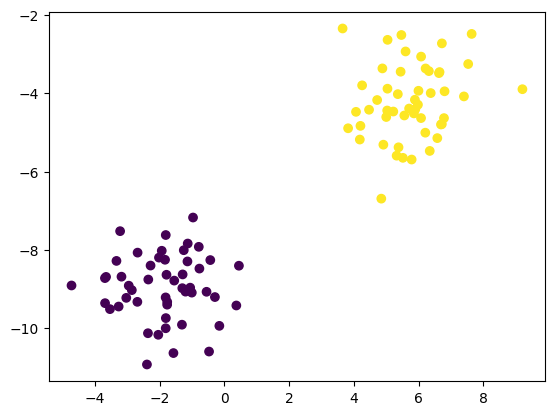

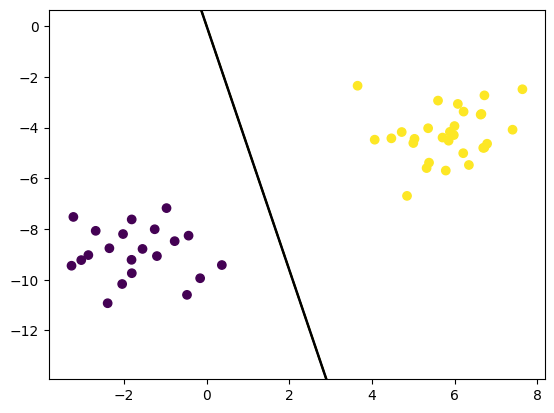

In [17]:
# Visualizing the scatter plot of the dataset
def visualize_dataset():
    plt.scatter(X[:, 0], X[:, 1], c=y)


# Visualizing SVM
def visualize_svm():
  def get_hyperplane_value(x, w, b, offset):
    return (-w[0] * x + b + offset) / w[1]

  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  plt.scatter(X_test[:, 0], X_test[:, 1], marker="o", c=y_test)

  x0_1 = np.amin(X_test[:, 0])
  x0_2 = np.amax(X_test[:, 0])

  x1_1 = get_hyperplane_value(x0_1, w, b, 0)
  x1_2 = get_hyperplane_value(x0_2, w, b, 0)

  x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
  x1_2_m = get_hyperplane_value(x0_2, w, b, -1)

  x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
  x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

  ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
  ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
  ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

  x1_min = np.amin(X[:, 1])
  x1_max = np.amax(X[:, 1])
  ax.set_ylim([x1_min - 3, x1_max + 3])

  plt.show()


visualize_dataset()
visualize_svm()